In [1]:
#hide
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
#hide
%load_ext autoreload
%autoreload 2

%matplotlib inline
%cd /content/gdrive/My Drive/Colab Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [3]:
__all__='Dataset getdls DataBunch image_extensions get_files ItemList ImageList Transform MakeRGB ResizeFixed to_byte_tensor to_float_tensor to_mask_tensor grandparent_splitter parent_splitter random_splitter SplitData Processor CategoryProcessor parent_labeler label_by_func LabelData'.split(" ")

In [ ]:
#hide
__all__

['Dataset',
 'getdls',
 'DataBunch',
 'image_extensions',
 'get_files',
 'ItemList',
 'ImageList',
 'Transform',
 'MakeRGB',
 'ResizeFixed',
 'to_byte_tensor',
 'to_float_tensor',
 'grandparent_splitter',
 'SplitData',
 'Processor',
 'CategoryProcessor',
 'parent_labeler',
 'label_by_func',
 'LabelData',
 'show_batch']

In [ ]:
#hide
# !git clone https://github.com/prajwal-suresh13/dl_lib.git

In [4]:
from dl_lib.core.utils import *

In [ ]:
#hide
# from fastdownload import FastDownload
# d = FastDownload(base = '/content/gdrive/My Drive/Colab Notebooks/fastai-coursev3/')
d=FastDownload()
d.get('https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz')

Path('/root/.fastdownload/data/imagenette2-160')

In [ ]:
#hide
path=Path('/root/.fastdownload/data/imagenette2-160')

In [ ]:
#hide
(path/'train').ls()

[Path('/root/.fastdownload/data/imagenette2-160/train/n03445777'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n02102040'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n03000684'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n03417042'),
 Path('/root/.fastdownload/data/imagenette2-160/train/.DS_Store'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n03425413'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n02979186'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n03028079'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n03394916'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n03888257'),
 Path('/root/.fastdownload/data/imagenette2-160/train/n01440764')]

# Dataset, DataLoader and DataBunch

In [ ]:
class Dataset():
  def __init__(self,x,y):self.x, self.y = x,y
  def __getitem__(self,i): return self.x[i], self.y[i]
  def __len__(self): return len(self.x)

In [ ]:
def getdls(train_ds, valid_ds, batchsize,**kwargs):
  return DataLoader(train_ds,batch_size=batchsize, shuffle=True, **kwargs),DataLoader(valid_ds, batch_size=batchsize*2, shuffle=False, **kwargs)

In [ ]:
class DataBunch():
  def __init__(self,train_dl,valid_dl, c_in=None, c_out=None):
    self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl,valid_dl, c_in, c_out

  @property
  def train_ds(self): return self.train_dl.dataset

  @property
  def valid_ds(self): return self.valid_dl.dataset


# ItemList, ImageList

In [ ]:
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/'))

In [ ]:
def _get_files(path,fs,extensions=None):
  path = Path(path)
  res = [path/f for f in fs if not f.startswith('.')
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
  return res

In [ ]:
def get_files(path,extensions=None, recurse=False, include=None):
  path = Path(path)
  extensions = setify(extensions)
  extensions = {e.lower() for e in extensions}

  if recurse:
    res=[]
    for i,(p,ds,fs) in enumerate(os.walk(path)):
      if include is not None and i==0 : ds[:] =[d for d in ds if d in include]
      else                            : ds[:] =[d for d in ds if not d.startswith('.')]
      res += _get_files(p,fs,extensions)
    return res
  else:
    fs = [o.name for o in os.scandir(path) if o.is_file()]
    return _get_files(path, fs,extensions)

In [ ]:
class ItemList(ListContainer):
  def __init__(self,items, path='.', tfms=None):
    super().__init__(items)
    self.path, self.tfms = Path(path), tfms

  def __getitem__(self,idx):
    res = super().__getitem__(idx)
    if isinstance(res,list): return [self._get(o) for o in res]
    return self._get(res)

  def get(self,i):
    return i

  def _get(self,i):
    return compose(self.get(i),self.tfms)

  def new(self,items, cls=None):
    if cls is None:cls = self.__class__
    return cls(items, path=self.path, tfms=self.tfms)

  def __repr__(self):
    return f'{super().__repr__()}\nPath : {self.path} \n Transforms : {self.tfms}'

In [ ]:
class ImageList(ItemList):
  def get(self, fn):return PIL.Image.open(fn)

  @classmethod
  def from_folder(cls, path, extensions=None, recurse=True, include=None, tfms=None):
    if extensions is None: extensions =image_extensions
    return cls(get_files(path, extensions, recurse=recurse, include=include),path, tfms=tfms)

In [ ]:
#hide
il = ImageList.from_folder(path)

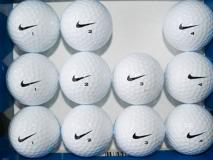

In [ ]:
#hide
il[0]

# Transforms

In [ ]:
class Transform(): _order=0

class MakeRGB(Transform):
  _order = 0
  def __call__(self,x): return x.convert('RGB')

class ResizeFixed(Transform):
  _order = 10
  def __init__(self,size):
    if isinstance(size, int):size=(size,size)
    self.size=size

  def __call__(self,x): return x.resize(self.size,PIL.Image.BILINEAR)

def to_byte_tensor(x):
  res = torch.ByteTensor(torch.ByteStorage.from_buffer(x.tobytes()))
  w,h = x.size
  return res.view(h,w,-1).permute(2,0,1)  #pytorch [channel,height,width] ;pil [height,width,channel]

to_byte_tensor._order=20

def to_float_tensor(x):
  return x.float().div_(255.)

to_float_tensor._order=30

In [ ]:
def to_mask_tensor(x):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(x.tobytes()))
    w,h = x.size
    res = res.view(h,w,-1).permute(2,0,1)
    return res.type(torch.LongTensor).squeeze(0)

to_mask_tensor._order=40

In [ ]:
#hide
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]

il= ImageList.from_folder(path,tfms=tfms)

In [ ]:
#hide
il

ImageList (13394 items) 
[Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2563.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5333.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5485.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_7794.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_715.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_3168.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_4814.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2709.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_8829.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_36.JPEG')...]
Path : /root/.fastdownload/data/imagenette2-160 
 Transforms : [<__main__.MakeRGB object at 0x7f6088409190>, <__ma

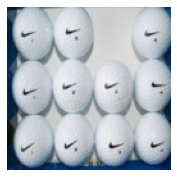

In [ ]:
#hide
show_image(il[0])

# SplitData

In [ ]:
def _split_by_func(items, f):
  mask = [f(o) for o in items]

  train = [o for o,m in zip(items,mask) if m==False]
  valid = [o for o,m in zip(items,mask) if m==True]

  return train,valid

In [ ]:
def parent_splitter(fn, valid_name='valid', train_name='train'):
  gp = fn.parent.name
  return True if gp==valid_name else False if gp==train_name else None

In [ ]:
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
  gp = fn.parent.parent.name
  return True if gp==valid_name else False if gp==train_name else None

In [ ]:
def random_splitter(fn, p_valid): return random.random() < p_valid

In [ ]:
#hide
train,valid = _split_by_func(il,partial(grandparent_splitter,valid_name='val'))

In [ ]:
#hide
len(train),len(valid)

(9469, 3925)

In [ ]:
class SplitData():
  def __init__(self,train,valid):self.train, self.valid = train, valid

  @classmethod
  def split_by_func(cls,items,func):
    train,valid = map(items.new, _split_by_func(items,func))
    return cls(train,valid)

  def __getattr__(self, k): return getattr(self.train, k)

  def __repr__(self):
    return f'{self.__class__.__name__}\nTrain: {self.train} \nValid: {self.valid}\n'

  @classmethod
  def to_databunch(self, sd, bs, c_in=None, c_out=None, **kwargs):
    dls = getdls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

In [ ]:
#hide
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
sd

SplitData
Train: ImageList (9469 items) 
[Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2563.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5333.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5485.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_7794.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_715.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_3168.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_4814.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2709.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_8829.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_36.JPEG')...]
Path : /root/.fastdownload/data/imagenette2-160 
 Transforms : [<__main__.MakeRGB object at 0x7f60

In [ ]:
#hide
sd.valid.tfms

 <function __main__.to_byte_tensor(x)>,
 <function __main__.to_float_tensor(x)>]

# LabelData

In [ ]:
class Processor():
  def process(self,items): return items

class CategoryProcessor(Processor):
  def __init__(self): self.vocab = None

  def __call__(self,items):
    if self.vocab is None:
      self.vocab = uniqueify(items)
      self.otoi = {item:num for num,item in enumerate(self.vocab)}
    return [self.proc1(o) for o in items]

  def proc1(self,item):return self.otoi[item]

  def deprocess(self,idx):
    assert self.vocab is not None
    return [self.deproc1(i) for i in idx]

  def deproc1(self,idx):return self.vocab[idx]

In [ ]:
def _label_by_func(ds, f, cls=ItemList,tfms=None):return cls([f(o) for o in ds], path=ds.path, tfms=tfms)

def parent_labeler(fn): return fn.parent.name

In [ ]:
#hide
l = _label_by_func(sd.valid, parent_labeler)

In [ ]:
#hide
l

ItemList (3925 items) 
['n03445777', 'n03445777', 'n03445777', 'n03445777', 'n03445777', 'n03445777', 'n03445777', 'n03445777', 'n03445777', 'n03445777'...]

Path : /root/.fastdownload/data/imagenette2-160 
 Transforms : None

In [ ]:
class LabelData():
  def process(self, il, proc):
    return il.new(compose(il.items, proc))

  def __init__(self, x, y, proc_x=None, proc_y=None):
    self.x_obj_all, self.y_obj_all = x,y
    self.x, self.y = self.process(x,proc_x), self.process(y, proc_y)
    self.proc_x, self.proc_y = proc_x, proc_y



  def __repr__(self): return f'{self.__class__.__name__} \nx : {self.x} \ny : {self.y}\n'

  def __getitem__(self,idx): return self.x[idx],self.y[idx]
  def __len__(self): return len(self.x)

  def x_obj(self,idx): return self.obj(self.x, idx, self.proc_x)
  def y_obj(self,idx): return self.obj(self.y, idx, self.proc_y)

  def obj(self,items, idx, procs):
    isint = isinstance(idx,int)
    item = items[idx]
    for proc in reversed(listify(procs)):
      item = proc.deproc1(item) if isint else proc.deprocess(item)
    return item

  @classmethod
  def label_by_func(cls, il, func,proc_x=None, proc_y=None,y_class=ItemList,y_tfms=None ):
    return cls(il, _label_by_func(il, func, y_class, y_tfms), proc_x=proc_x, proc_y=proc_y)


In [ ]:
#hide
pro = CategoryProcessor()

In [ ]:
#hide
labeledtrain = LabelData.label_by_func(sd.train, parent_labeler, proc_y=pro)
labeledtrain

LabelData 
x : ImageList (9469 items) 
[Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2563.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5333.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5485.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_7794.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_715.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_3168.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_4814.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2709.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_8829.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_36.JPEG')...]
Path : /root/.fastdownload/data/imagenette2-160 
 Transforms : [<__main__.MakeRGB object at 0x7f6088

In [ ]:
#hide
labeledvalid = LabelData.label_by_func(sd.valid, parent_labeler, proc_y=pro)
labeledvalid

LabelData 
x : ImageList (3925 items) 
[Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_17511.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_172.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_1311.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_3011.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_9102.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/ILSVRC2012_val_00020502.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_7442.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_1452.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/ILSVRC2012_val_00014102.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/val/n03445777/n03445777_1482.JPEG')...]
Path : /root/.fastdownload/data/imagenette2-160 
 Transforms : [<__main__.MakeRGB object at 0x7f608

In [ ]:
#hide
labeledvalid.proc_y ==labeledtrain.proc_y

False

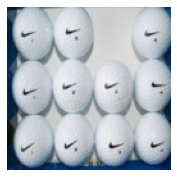

In [ ]:
#hide
show_image(labeledtrain[0][0])

In [ ]:
def label_by_func(sd, func, proc_x=None, proc_y=None,y_class=ItemList,y_tfms=None ):
  train = LabelData.label_by_func(sd.train, func, proc_x=proc_x, proc_y=proc_y,  y_class=y_class, y_tfms=y_tfms)
  valid = LabelData.label_by_func(sd.valid, func, proc_x=proc_x, proc_y=proc_y, y_class=y_class, y_tfms=y_tfms)
  return SplitData(train,valid)


In [ ]:
#hide
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
ll

SplitData
Train: LabelData 
x : ImageList (9469 items) 
[Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2563.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5333.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_5485.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_7794.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_715.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_3168.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_4814.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_2709.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_8829.JPEG'), Path('/root/.fastdownload/data/imagenette2-160/train/n03445777/n03445777_36.JPEG')...]
Path : /root/.fastdownload/data/imagenette2-160 
 Transforms : [<__main__.MakeRGB o

In [ ]:
#hide
ll.train.proc_y == ll.valid.proc_y

True

# DataBunch

In [ ]:
#hide
tfms = [MakeRGB(), ResizeFixed(128), to_byte_tensor, to_float_tensor]

il = ImageList.from_folder(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())
data = ll.to_databunch(ll, 64, 3,10)

In [ ]:
#hide
data.c_in, data.c_out

(3, 10)

In [ ]:
#hide
data.train_dl

In [ ]:
#hide
x = next(iter(data.train_dl))

In [ ]:
#hide
for i in x: print(i.shape)

torch.Size([64, 3, 128, 128])
torch.Size([64])


In [ ]:
#hide
show_batch(x[0])

Output hidden; open in https://colab.research.google.com to view.

In [7]:
#hide
!pip install fire
!python dl_lib/notebook2script.py notebooks/core/datablock.ipynb dl_lib/core

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Converted notebooks/core/datablock.ipynb to dl_lib/core/datablock.py
